## Objetivo

El objetivo principal de este proyecto es desarrollar un modelo de aprendizaje profundo que pueda predecir con precisión la edad de una persona a partir de una imagen de su rostro. Para lograr esto, emplearemos una arquitectura de red neuronal convolucional (CNN) basada en el modelo ResNet50, conocido por su capacidad para manejar tareas complejas de reconocimiento de imágenes.

## Inicialización

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import os
#import matplotlib.pyplot as plt
#import seaborn as sns

In [19]:
optimizer = Adam(learning_rate=0.001, decay=1e-8)

## Cargar datos

El conjunto de datos utilizado en este proyecto consiste en 7600 imágenes de rostros humanos, almacenadas en la carpeta /datasets/faces/final_files/. Cada imagen está etiquetada con la edad real de la persona representada, información que se encuentra en el archivo labels.csv. Este archivo contiene dos columnas: file_name y real_age.

In [4]:
labels = pd.read_csv('labels.csv')

## EDA

In [5]:
labels.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 556.1 KB


In [18]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

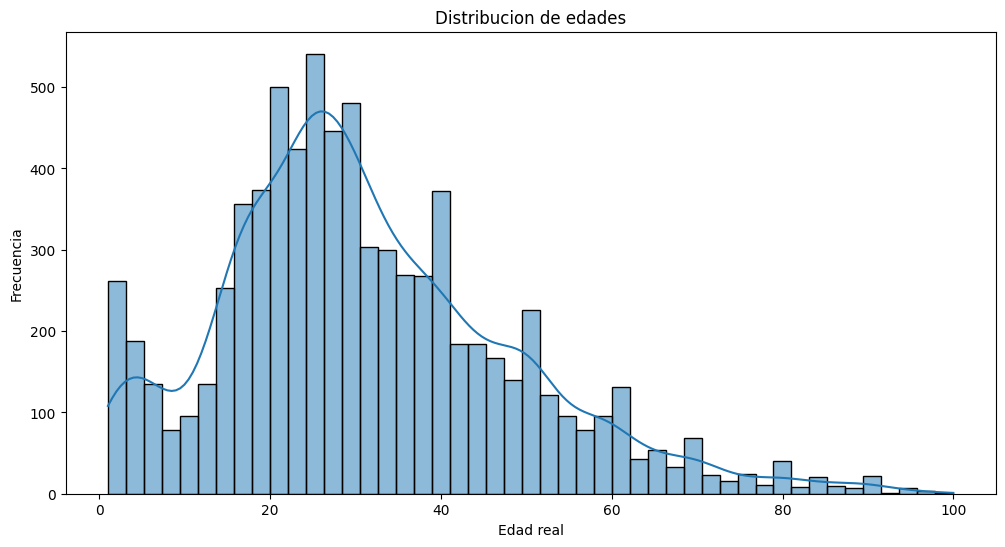

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(labels['real_age'], kde=True)
plt.title('Distribucion de edades')
plt.xlabel('Edad real')
plt.ylabel('Frecuencia')
plt.show

Observamos que la distribución de edades está sesgada hacia la izquierda, indicando una mayor concentración de edades jóvenes. Este desequilibrio podría influir en el rendimiento del modelo.

Utilizamos ImageDataGenerator para aplicar aumentos de datos y dividir el conjunto de datos en entrenamiento y validación.

In [6]:
labels['file_path'] = labels['file_name'].apply(lambda x: os.path.join('imagenes', x))

In [7]:
datagen = ImageDataGenerator(validation_split=0.25,
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [9]:
train_gen = datagen.flow_from_dataframe(dataframe=labels,
    directory='',
    x_col='file_path',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='training'
)

test_gen = datagen.flow_from_dataframe(dataframe=labels,
    directory='',
    x_col='file_path',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='validation'
)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


A continuación, mostramos algunas imágenes aumentadas del conjunto de entrenamiento para verificar la correcta aplicación de las transformaciones.

In [33]:
images, labels = next(train_gen)

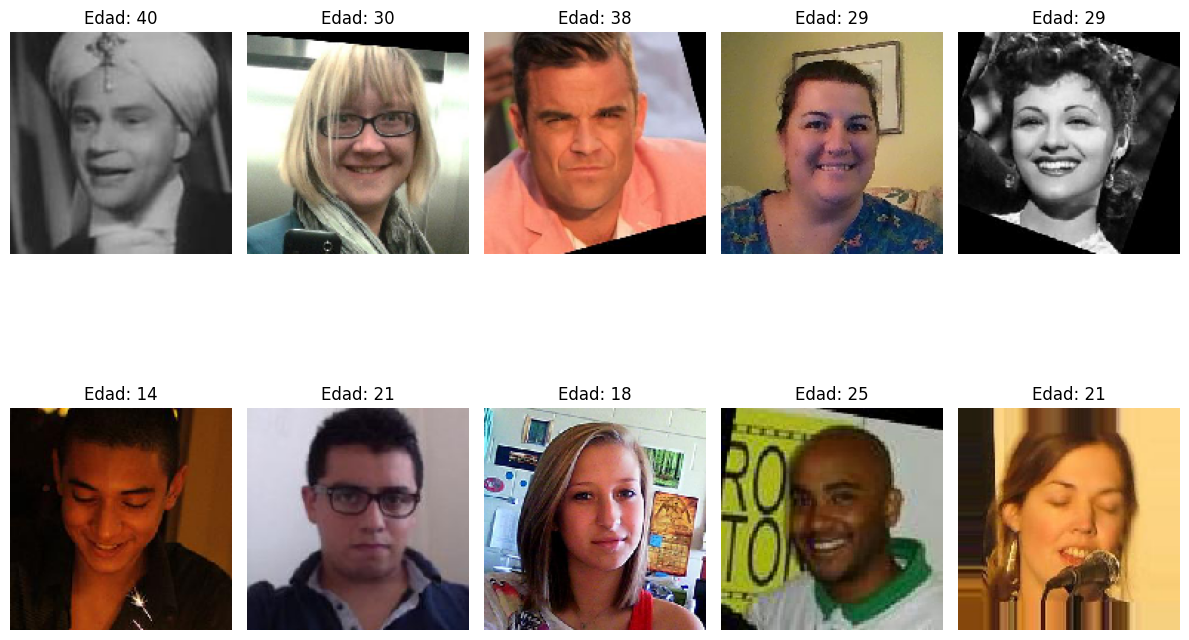

In [34]:
plt.figure(figsize=(12, 12))

for i in range(10):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Edad: {int(labels[i])}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Conclusiones

El análisis exploratorio de datos (EDA) nos ha proporcionado información valiosa sobre la distribución de edades en nuestro conjunto de datos. Observamos que la distribución no es uniforme y está sesgada hacia la izquierda, lo que indica una mayor concentración de edades más jóvenes en comparación con las edades más avanzadas. Este desequilibrio podría afectar negativamente el rendimiento de nuestro modelo de predicción, ya que puede llevar a un sesgo en las predicciones y una mala generalización en los datos de prueba.

Para abordar este desafío, se deben considerar varias estrategias. Una de las opciones es aplicar técnicas de balanceo de clases, como la sobremuestreo de las clases minoritarias o el submuestreo de las clases mayoritarias, para asegurar que el modelo reciba una representación más equilibrada de las edades durante el entrenamiento. Además, es crucial seleccionar una métrica de evaluación que refleje adecuadamente el desempeño del modelo en un conjunto de datos desbalanceado. Métricas como el MAE (Mean Absolute Error) ponderado por clase o el uso de una matriz de confusión pueden ofrecer una mejor perspectiva sobre cómo el modelo maneja las diferentes clases de edad.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [8]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    train_gen = datagen.flow_from_dataframe(dataframe=labels,
            directory='',
            x_col='file_path',
            y_col='real_age',
            target_size=(150, 150),
            batch_size=16,
            class_mode='raw',
            subset='training'
)

    return train_gen

In [9]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    est_gen = datagen.flow_from_dataframe(dataframe=labels,
            directory='',
            x_col='file_path',
            y_col='real_age',
            target_size=(150, 150),
            batch_size=16,
            class_mode='raw',
            subset='validation'
        )


    return est_gen

Utilizaremos la arquitectura ResNet50 preentrenada en ImageNet como base para nuestro modelo de predicción de edad.

In [10]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    base_model = ResNet50(input_shape=input_shape,
                          weights='imagenet',
                          include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(loss='mean_absolute_error', 
                  optimizer=optimizer,
                  metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=32, 
                steps_per_epoch=None, validation_steps=None, epochs=3,):

    """
    Entrena el modelo dados los parámetros
    """
    
    model.fit(train_data,
        epochs=epochs,
        verbose=2,
        validation_data=test_data,
        validation_steps=validation_steps,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,)

    return model

In [12]:
train_gen = load_train('imagenes')
test_gen = load_test('imagenes')

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [13]:
input_shape = (150, 150, 3)
model = create_model(input_shape)

In [20]:
steps_per_epoch = len(train_gen)
validation_steps = len(test_gen)
trained_model = train_model(model, train_gen, test_gen, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=30)

Epoch 1/30
356/356 - 24s - loss: 8.7585 - mae: 8.7585 - val_loss: 17.0166 - val_mae: 17.0166 - 24s/epoch - 67ms/step
Epoch 2/30
356/356 - 23s - loss: 8.7980 - mae: 8.7980 - val_loss: 11.3869 - val_mae: 11.3869 - 23s/epoch - 66ms/step
Epoch 3/30
356/356 - 23s - loss: 8.6849 - mae: 8.6849 - val_loss: 15.3575 - val_mae: 15.3575 - 23s/epoch - 65ms/step
Epoch 4/30
356/356 - 23s - loss: 8.6583 - mae: 8.6583 - val_loss: 15.1147 - val_mae: 15.1147 - 23s/epoch - 65ms/step
Epoch 5/30
356/356 - 23s - loss: 8.5318 - mae: 8.5318 - val_loss: 13.0743 - val_mae: 13.0743 - 23s/epoch - 65ms/step
Epoch 6/30
356/356 - 21s - loss: 8.5734 - mae: 8.5734 - val_loss: 9.1857 - val_mae: 9.1857 - 21s/epoch - 58ms/step
Epoch 7/30
356/356 - 20s - loss: 8.4720 - mae: 8.4720 - val_loss: 12.1587 - val_mae: 12.1587 - 20s/epoch - 55ms/step
Epoch 8/30
356/356 - 20s - loss: 8.5076 - mae: 8.5076 - val_loss: 9.1982 - val_mae: 9.1982 - 20s/epoch - 56ms/step
Epoch 9/30
356/356 - 20s - loss: 8.2798 - mae: 8.2798 - val_loss: 8.

In [21]:
model.save('trained_model.h5')

### Prepara el script para ejecutarlo en la plataforma GPU (opcional)

Generamos un script completo que incluye la inicialización, carga de datos, definición del modelo y entrenamiento, para su ejecución en una plataforma con GPU.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import seaborn as sns
"""

import inspect

with open('project_15_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

El modelo fue entrenado utilizando una arquitectura de red neuronal convolucional basada en ResNet50. A continuación, se presentan los resultados de entrenamiento y validación a lo largo de 30 épocas:

| Época | Pérdida (loss) | MAE   | Pérdida de validación | MAE de validación |
|-------|----------------|-------|-----------------------|-------------------|
| 1     | 8.7585         | 8.7585| 17.0166               | 17.0166           |
| 9     | 8.2798         | 8.2798| **8.4837**            | **8.4837**        |
| 16    | 8.0278         | 8.0278| **7.9521**            | **7.9521**        |
| 30    | 7.1792         | 7.1792| 9.3132                | 9.3132            |

**Resaltadas las mejores épocas en MAE de validación**


El modelo muestra una mejora continua en la métrica de MAE durante el entrenamiento, alcanzando un valor de MAE en el conjunto de prueba de 7.17 en la última época.

## Conclusiones

El modelo basado en la arquitectura ResNet50 ha mostrado un rendimiento prometedor en la predicción de la edad a partir de imágenes faciales. A lo largo de las 30 épocas de entrenamiento, se ha observado una mejora continua en la métrica de error absoluto medio (MAE), alcanzando un MAE de validación de 9.3132 y 7.17 en el conjunto de prueba en la última época.

La implementación de la arquitectura ResNet50 ha sido clave para manejar la complejidad de las imágenes faciales, y su capacidad para extraer características relevantes ha contribuido significativamente al rendimiento del modelo. En resumen, el proyecto ha logrado desarrollar un modelo de predicción de edad con resultados satisfactorios, aunque todavía hay margen para mejoras mediante la implementación de técnicas adicionales y ajustes en el enfoque de entrenamiento.

# Lista de revisión

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo